In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [93]:
# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [94]:
import json

def nps_seq_to_tensor(seq):
    return torch.tensor(seq, dtype=torch.float32).reshape((-1, 1, 1))

class ChartDataset(Dataset):

    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)

        self.data_tensors = list(map(
            lambda seq: nps_seq_to_tensor(json.loads(seq)),
            df['NPS sequence']
        ))
        self.meter_tensors = list(map(
            lambda m: torch.tensor([[m]], dtype=torch.float32),
            df['Meter']
        ))
        
    
    def __len__(self):
        return len(self.data_tensors)
    
    def __getitem__(self, i):
        return self.meter_tensors[i], self.data_tensors[i]

In [95]:
all_data = ChartDataset('rnn_dataset.csv')
print(f'loaded {len(all_data)} items')
print(f'example = {all_data[0]}')

loaded 1666 items
example = (tensor([[11.]], device='cuda:0'), tensor([[[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[0.]],

        [[1.]],

        [[4.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[9.]],

        [[3.]],

        [[6.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[5.]],

        [[5.]],

        [[5.]],

        [[6.]],

        [[5.]],

        [[5.]],

        [[6.]],

        [[5.]],

        [[6.]],

        [[5.]],

        [[4.]],

        [[6.]],

        [[5.]],

        [[7.]],

        [[6.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

        [[9.]],

        [[8.]],

  

In [96]:
train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 1333, validation examples = 333


In [97]:
class RatingRNN(nn.Module):
    def __init__(self, hidden_size):
        super(RatingRNN, self).__init__()

        self.rnn = nn.RNN(1, hidden_size, nonlinearity='relu')
        self.h2o = nn.Linear(hidden_size, 1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])

        return output

In [102]:
rnn = RatingRNN(32)
print(rnn)

RatingRNN(
  (rnn): RNN(1, 32)
  (h2o): Linear(in_features=32, out_features=1, bias=True)
)


In [112]:
bpm = 10000
inp = nps_seq_to_tensor([bpm*4/60]*round(60/bpm/4*16*32))
out = rnn(inp)
print(out)

tensor([[53.5026]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [104]:
import random

def train(rnn, training_data, n_epoch=10, n_batch_size=64, report_every=50, learning_rate=0.2, criterion=nn.MSELoss()):
    """
    Learn on a batch of training_data for a specified number of iterations and reporting thresholds
    """
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    # start = time.time()
    print(f"training on data set with n = {len(training_data)}")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear the gradients

        # create some minibatches
        # we cannot use dataloaders because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size )

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch: #for each example in this batch
                (meter_tensor, seq_tensor) = training_data[i]
                output = rnn.forward(seq_tensor)
                loss = criterion(output, meter_tensor)
                batch_loss += loss

            # optimize parameters
            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)

        all_losses.append(current_loss / len(batches) )
        if iter % report_every == 0:
            print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
        current_loss = 0

    return all_losses

In [105]:
import time

start = time.time()
all_losses = train(rnn, train_set, n_epoch=600, learning_rate=3e-4, report_every=1)
end = time.time()
print(f"training took {end-start}s")

training on data set with n = 1333
1 (0%): 	 average batch loss = 505.34300717647545
2 (0%): 	 average batch loss = 500.45008215315465
3 (0%): 	 average batch loss = 495.7884829006601
4 (1%): 	 average batch loss = 491.2391457573637
5 (1%): 	 average batch loss = 487.11284243731643
6 (1%): 	 average batch loss = 483.4933893211499
7 (1%): 	 average batch loss = 480.21049530843646
8 (1%): 	 average batch loss = 476.7673401679457
9 (2%): 	 average batch loss = 473.230740407515
10 (2%): 	 average batch loss = 469.73564313994655
11 (2%): 	 average batch loss = 466.223423498629
12 (2%): 	 average batch loss = 462.5757798145281
13 (2%): 	 average batch loss = 458.9663331955279
14 (2%): 	 average batch loss = 455.21549613880177
15 (2%): 	 average batch loss = 451.05214653826044
16 (3%): 	 average batch loss = 446.91307882639364
17 (3%): 	 average batch loss = 442.6135004355
18 (3%): 	 average batch loss = 438.0198258529793
19 (3%): 	 average batch loss = 433.2228593140476
20 (3%): 	 average ba

0.34534534534534533


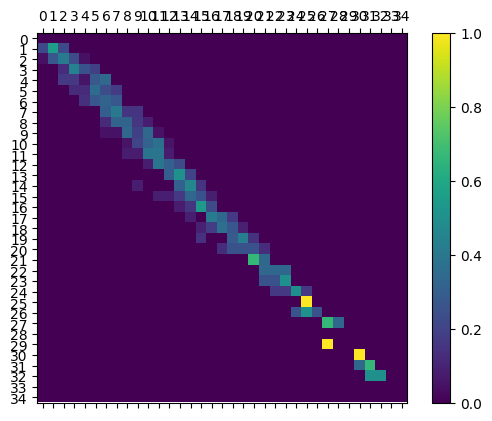

In [113]:
def evaluate(rnn, testing_data):
    width = 43-11+3
    confusion = torch.zeros(width, width)

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        count = 0
        for i in range(len(testing_data)):
            (meter_tensor, seq_tensor) = testing_data[i]
            guess = rnn(seq_tensor)
            true_meter = int(meter_tensor.item())
            guess_meter = round(guess.item())
            guess_meter = max(10, min(44, guess_meter))
            if true_meter == guess_meter:
                count += 1
            confusion[true_meter - 10][guess_meter - 10] += 1
        print(count / len(testing_data))

    # Normalize by dividing every row by its sum
    for i in range(width):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(width))
    ax.set_yticks(np.arange(width))

    # Force label at every tick
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set)

In [115]:
torch.save(rnn.state_dict(), 'cp_32hidden_600epochs.pt')

In [114]:
print(rnn.rnn.all_weights)

[[Parameter containing:
tensor([[-0.0625],
        [ 0.1647],
        [-0.0424],
        [-0.0252],
        [-0.1291],
        [-0.2163],
        [-0.1198],
        [ 0.0428],
        [-0.0169],
        [-0.1813],
        [-0.0192],
        [ 0.0585],
        [ 0.0841],
        [ 0.1422],
        [ 0.0791],
        [-0.1569],
        [-0.0407],
        [-0.1301],
        [ 0.1153],
        [-0.0475],
        [-0.2394],
        [ 0.0349],
        [ 0.1424],
        [ 0.1089],
        [-0.1378],
        [ 0.1503],
        [-0.0650],
        [-0.1713],
        [-0.0723],
        [ 0.0421],
        [ 0.1052],
        [ 0.1942]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.0372, -0.1474,  0.0916,  ...,  0.0340,  0.1183,  0.1203],
        [-0.0886, -0.0579,  0.0890,  ...,  0.0412,  0.0253, -0.0637],
        [ 0.0885, -0.1621,  0.0288,  ..., -0.0190,  0.1693,  0.0865],
        ...,
        [-0.0014,  0.1359, -0.0868,  ...,  0.0093, -0.0762, -0.0965],
        [-0.10